# Gather Data

In [1]:
import requests
from lxml import html
import pandas as pd

First, let's define the car that we want information

In [7]:
ROOT_URL = 'https://carros.tucarro.com.co/'
BRAND = 'mercedes-benz'
MODEL = 'clase-c'
VERSION = '180'

In [3]:
url = ROOT_URL+BRAND+'/'+MODEL+'/'

Let's create a function to download the webpage with the car provided. 

In [4]:
def download(url, user_agent='wswp', num_retries=2, print_url=False):
    if (print_url):
        print ('Downloading: ',url)
    headers = {'User-Agent': user_agent}
    try:
        resp = requests.get(url, headers=headers)
        if resp.status_code >= 400:
            print('Download error:', resp.text)
            if num_retries and 500 <= resp.status_code < 600:
                return download(url, num_retries - 1)
        else:
            return resp
    except requests.exceptions.RequestException as e:
        print('Download error: ', e)

In [5]:
pageContent = download(url)

In [6]:
print(pageContent)

<Response [200]>


Now, we have to check how many pages we will have to scrape. We will do this with the get_address_list function

In [7]:
def get_address_list(pageContent):
    tree = html.fromstring(pageContent.content)
    address_elements = tree.xpath(
        '//li[contains(@class,"andes-pagination__button")]')

    address_list = []
    for element in address_elements:
        raw_address = element.xpath('.//a/@href')
        address = ' '.join(' '.join(raw_address).split())

        address_list.append(address)

    address_list[0] = url
    address_list.pop()

    return address_list

In [8]:
address_list = get_address_list(pageContent)

In [9]:
address_list

['https://carros.tucarro.com.co/mercedes-benz/clase-c/',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_49',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_97',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_145',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_193',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_241',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_289',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_337',
 'https://carros.tucarro.com.co/mercedes-benz/clase-c/_Desde_385']

Now, we will start scraping the information od every car. We will loop trough the urls and append the information to a list.

In [10]:
def get_information(address_list):
    scraped_products = []
    for url in address_list:
        pageContent = download(url)
        tree = html.fromstring(pageContent.content)

        product_listings = tree.xpath(
            '//div[contains(@class,"rowItem item highlighted item--grid item--has-row-logo new")]')

        for product in product_listings:
            raw_url = product.xpath('.//div[@class="images-viewer"]/@item-url')
            raw_price = product.xpath(
                ".//div[contains(@class,'item__price')]//span[@class='price__fraction']//text()")
            raw_year = product.xpath('.//div[@class="item__attrs"]//text()')
            raw_name = product.xpath(
                ".//h2[contains(@class,'item__title list-view-item-title')]//span[@class='main-title']//text()")
            raw_id = product.xpath('.//div[@class="images-viewer"]/@item-id')

            price = ' '.join(' '.join(raw_price).split())
            year = ' '.join(' '.join(raw_year).split())
            name = ' '.join(' '.join(raw_name).split())
            ID = ' '.join(' '.join(raw_id).split())
            data = {
                'url': raw_url[0],
                'price': price,
                'year': year,
                'name': name,
                'ID': ID
            }
            scraped_products.append(data)

    for url in scraped_products:
        pageContent = download(url['url'])
        details = html.fromstring(pageContent.content)

        details_listings = details.xpath('//li[contains(@class,"specs-item")]')

        for product in details_listings:
            raw_spec = product.xpath(".//strong//text()")
            raw_value = product.xpath(".//span//text()")
            spec = ' '.join(' '.join(raw_spec).split())
            value = ' '.join(' '.join(raw_value).split())

            url.update({spec: value})

    df = pd.DataFrame(scraped_products)
    return df

In [11]:
df = get_information(address_list)

In [12]:
df.head()

,url,price,year,name,ID,Marca,Modelo,Versión,Año,Cilindrada,Kilómetros,Puertas,Tipo de combustible,Placa
0,https://articulo.tucarro.com.co/MCO-548377895-...,26.900.000,2005 | 140000 km,Mercedes-benz Clase C C320,MCO548377895,Mercedes-Benz,Clase C,C320,2005,3.199 cc,140.000 km,5,Gasolina,FAW265
1,https://articulo.tucarro.com.co/MCO-549745190-...,59.000.000,2012 | 59000 km,Mercedes-benz Clase C C200 Elegance 1.8 Turbo,MCO549745190,Mercedes-Benz,Clase C,C200 Elegance 1.8 Turbo,2012,1.8 cc,59.000 km,4,Gasolina,MBM947
2,https://articulo.tucarro.com.co/MCO-552274120-...,66.000.000,2015 | 92000 km,Mercedes-benz Clase C Avantgrade,MCO552274120,Mercedes-Benz,Clase C,Avantgrade,2015,NaN,92.000 km,5,Gasolina,impar
3,https://articulo.tucarro.com.co/MCO-551514710-...,81.500.000,2016 | 34900 km,Mercedes-benz Clase C C200 Exclusive,MCO551514710,Mercedes-Benz,Clase C,C200 EXCLUSIVE,2016,2000 cc,34.900 km,4,Gasolina,USV831
4,https://articulo.tucarro.com.co/MCO-551356381-...,115.475.000,2017 | 22320 km,Mercedes-benz Clase C C 200,MCO551356381,Mercedes-Benz,Clase C,C 200,2017,NaN,22.320 km,2,Gasolina,3


Finally, we save our in csv format.

In [13]:
df.to_csv('files/vehicles.csv', index=False)

# Clean Data

In [145]:
df = pd.read_csv('files/vehicles.csv')  

In [146]:
df.head()

,url,price,year,name,ID,Marca,Modelo,Versión,Año,Cilindrada,Kilómetros,Puertas,Tipo de combustible,Placa
0,https://articulo.tucarro.com.co/MCO-548377895-...,26.900.000,2005 | 140000 km,Mercedes-benz Clase C C320,MCO548377895,Mercedes-Benz,Clase C,C320,2005,3.199 cc,140.000 km,5.0,Gasolina,FAW265
1,https://articulo.tucarro.com.co/MCO-549745190-...,59.000.000,2012 | 59000 km,Mercedes-benz Clase C C200 Elegance 1.8 Turbo,MCO549745190,Mercedes-Benz,Clase C,C200 Elegance 1.8 Turbo,2012,1.8 cc,59.000 km,4.0,Gasolina,MBM947
2,https://articulo.tucarro.com.co/MCO-552274120-...,66.000.000,2015 | 92000 km,Mercedes-benz Clase C Avantgrade,MCO552274120,Mercedes-Benz,Clase C,Avantgrade,2015,NaN,92.000 km,5.0,Gasolina,impar
3,https://articulo.tucarro.com.co/MCO-551514710-...,81.500.000,2016 | 34900 km,Mercedes-benz Clase C C200 Exclusive,MCO551514710,Mercedes-Benz,Clase C,C200 EXCLUSIVE,2016,2000 cc,34.900 km,4.0,Gasolina,USV831
4,https://articulo.tucarro.com.co/MCO-551356381-...,115.475.000,2017 | 22320 km,Mercedes-benz Clase C C 200,MCO551356381,Mercedes-Benz,Clase C,C 200,2017,NaN,22.320 km,2.0,Gasolina,3


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   url                  402 non-null    object 
 1   price                402 non-null    object 
 2   year                 402 non-null    object 
 3   name                 402 non-null    object 
 4   ID                   402 non-null    object 
 5   Marca                402 non-null    object 
 6   Modelo               402 non-null    object 
 7   Versión              401 non-null    object 
 8   Año                  402 non-null    int64  
 9   Cilindrada           231 non-null    object 
 10  Kilómetros           402 non-null    object 
 11  Puertas              384 non-null    float64
 12  Tipo de combustible  402 non-null    object 
 13  Placa                395 non-null    object 
dtypes: float64(1), int64(1), object(12)
memory usage: 44.1+ KB


Let's rename our columns with proper python names.

In [148]:
df.rename(columns={'Año':'year2', 
                   'Marca':'brand', 
                   'Modelo':'model', 
                   'Versión':'version',
                   'Cilindrada':'engine',
                   'Kilómetros':'kms',
                   'Puertas':'doors',
                   'Tipo de combustible':'gasoline',
                   'Placa':'plate'}, 
          inplace=True)

In [149]:
df.head()

,url,price,year,name,ID,brand,model,version,year2,engine,kms,doors,gasoline,plate
0,https://articulo.tucarro.com.co/MCO-548377895-...,26.900.000,2005 | 140000 km,Mercedes-benz Clase C C320,MCO548377895,Mercedes-Benz,Clase C,C320,2005,3.199 cc,140.000 km,5.0,Gasolina,FAW265
1,https://articulo.tucarro.com.co/MCO-549745190-...,59.000.000,2012 | 59000 km,Mercedes-benz Clase C C200 Elegance 1.8 Turbo,MCO549745190,Mercedes-Benz,Clase C,C200 Elegance 1.8 Turbo,2012,1.8 cc,59.000 km,4.0,Gasolina,MBM947
2,https://articulo.tucarro.com.co/MCO-552274120-...,66.000.000,2015 | 92000 km,Mercedes-benz Clase C Avantgrade,MCO552274120,Mercedes-Benz,Clase C,Avantgrade,2015,NaN,92.000 km,5.0,Gasolina,impar
3,https://articulo.tucarro.com.co/MCO-551514710-...,81.500.000,2016 | 34900 km,Mercedes-benz Clase C C200 Exclusive,MCO551514710,Mercedes-Benz,Clase C,C200 EXCLUSIVE,2016,2000 cc,34.900 km,4.0,Gasolina,USV831
4,https://articulo.tucarro.com.co/MCO-551356381-...,115.475.000,2017 | 22320 km,Mercedes-benz Clase C C 200,MCO551356381,Mercedes-Benz,Clase C,C 200,2017,NaN,22.320 km,2.0,Gasolina,3


The dataset has repeated information in the year and year2 columns. Also, the dataset has columns that do not provide relevant information like model, brand, engine, doors, plate, ID, url. We will drop these columns. 

In [150]:
df.drop(['url','year','ID','brand','model','engine','doors','gasoline','plate'], axis=1, inplace=True)
df.rename(columns={'year2':'year'}, inplace=True)

In [151]:
df.head()

,price,name,version,year,kms
0,26.900.000,Mercedes-benz Clase C C320,C320,2005,140.000 km
1,59.000.000,Mercedes-benz Clase C C200 Elegance 1.8 Turbo,C200 Elegance 1.8 Turbo,2012,59.000 km
2,66.000.000,Mercedes-benz Clase C Avantgrade,Avantgrade,2015,92.000 km
3,81.500.000,Mercedes-benz Clase C C200 Exclusive,C200 EXCLUSIVE,2016,34.900 km
4,115.475.000,Mercedes-benz Clase C C 200,C 200,2017,22.320 km


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   price    402 non-null    object
 1   name     402 non-null    object
 2   version  401 non-null    object
 3   year     402 non-null    int64 
 4   kms      402 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


We'll need to conver kms to numeric.

In [153]:
df.kms = df.kms.str.split(' ').str[0].str.replace('.','').astype(int)

In [154]:
df.kms

0      140000
1       59000
2       92000
3       34900
4       22320
        ...  
397     66000
398    101000
399     45500
400     10000
401     22700
Name: kms, Length: 402, dtype: int32

The target variable price must be set to a numeric value and is in Millions of pesos. We can scale it to better manipulation.

In [155]:
df.price

0       26.900.000
1       59.000.000
2       66.000.000
3       81.500.000
4      115.475.000
          ...     
397     60.000.000
398     38.000.000
399     59.000.000
400     95.000.000
401     84.000.000
Name: price, Length: 402, dtype: object

In [156]:
df.price = df.price.str.replace('.','').astype(int)
df.price = df.price/1000000

In [157]:
df.price

0       26.900
1       59.000
2       66.000
3       81.500
4      115.475
        ...   
397     60.000
398     38.000
399     59.000
400     95.000
401     84.000
Name: price, Length: 402, dtype: float64

One important feature is the version of the vehicle. The dataset contains the vehicules of the model but it must be filtered by version. We have two options to get this information. Column Version and Column Name.

In [158]:
df.version.sample(5)

234    GLC 350 E COUPE HÍBRIDA
20             C250 AMG 2.0 AT
395            C200 KOMPRESSOR
265                    200 CGI
216         C 250 ANTIGUO 1978
Name: version, dtype: object

In [159]:
df.name.sample(5)

132    Mercedes-benz Clase C C180 Blue Eficienly 1.80...
157                      Mercedes-benz Clase C Exclusive
193                 Mercedes-benz Clase C C180 Cgi Turbo
279        Mercedes-benz Clase C C200 Cgi At Full Equipo
130                      Mercedes-benz Clase C C63 Coupe
Name: name, dtype: object

As thecolumn Name looks more complete than version column, I will filter the dataset by this column. As this is a entry form, users tend to fill more complete information at the beginning rather than at the end.

In [160]:
df_version = df[df.name.str.contains(pat = VERSION)].copy()

In [161]:
df_version.head()

,price,name,version,year,kms
6,86.9,Mercedes-benz Clase C C180,C180,2017,13500
11,49.9,Mercedes-benz Clase C C180 Cgi,C180 CGI,2013,86000
13,28.5,Mercedes-benz Clase C Clase C 180,Clase C 180,2005,118500
16,110.0,Mercedes-benz Clase C C180 Avantgarde,C180 AVANTGARDE,2019,19500
21,32.0,Mercedes-benz Clase C C 180 1.8 At Amg,C 180 1.8 AT AMG,2006,114400


Finally we can drop the name and version columns.

In [162]:
df_version.drop(['name','version'], axis=1, inplace=True)

In [163]:
df_version.head()

,price,year,kms
6,86.9,2017,13500
11,49.9,2013,86000
13,28.5,2005,118500
16,110.0,2019,19500
21,32.0,2006,114400


Ok, now lets write a function that does all of our data cleaning.

In [233]:
def prepareData(df):
    # Rename columns
    df.rename(columns={'Año':'year2', 
                   'Marca':'brand', 
                   'Modelo':'model', 
                   'Versión':'version',
                   'Cilindrada':'engine',
                   'Kilómetros':'kms',
                   'Puertas':'doors',
                   'Tipo de combustible':'gasoline',
                   'Placa':'plate'}, 
          inplace=True)
    
    # Drop unnecessary Columns
    df.drop(['url','year','ID','brand','model','engine','doors','gasoline','plate'], axis=1, inplace=True)
    df.rename(columns={'year2':'year'}, inplace=True)
    
    # Transform kms to numeric
    df.kms = df.kms.str.split(' ').str[0].str.replace('.','').astype(int)
    
    # Transform price to numeric and scale
    df.price = df.price.str.replace('.','').astype(int)
    df.price = df.price/1000000
    
    # Filter data by VERSION
    df_version = df[df.name.str.contains(pat = VERSION)].copy()
    df_version.drop(['name','version'], axis=1, inplace=True)
    
    # Reset Index
    df_version.reset_index(inplace= True, drop = True)
    
    return df_version    

Now let's test prepareData function:

In [294]:
df = pd.read_csv('files/vehicles.csv')
df = prepareData(df)
df.head()

,price,year,kms
0,86.9,2017,13500
1,49.9,2013,86000
2,28.5,2005,118500
3,110.0,2019,19500
4,32.0,2006,114400


In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   162 non-null    float64
 1   year    162 non-null    int64  
 2   kms     162 non-null    int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 3.3 KB


## Data Assessment

In [296]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')

First lets check the distribution of our attributes

In [297]:
df.head()

,price,year,kms
0,86.9,2017,13500
1,49.9,2013,86000
2,28.5,2005,118500
3,110.0,2019,19500
4,32.0,2006,114400


In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   162 non-null    float64
 1   year    162 non-null    int64  
 2   kms     162 non-null    int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 3.3 KB


### Year Attribute

In [299]:
df.year.value_counts()

2012    25
2013    17
2016    16
2009    13
2015    12
2014    11
2017    10
2007     9
2011     9
2020     8
2006     8
2019     7
2010     4
2008     3
2018     3
2005     3
2003     1
1999     1
1998     1
1962     1
Name: year, dtype: int64

Text(9.924999999999997, 0.5, 'Frequency')

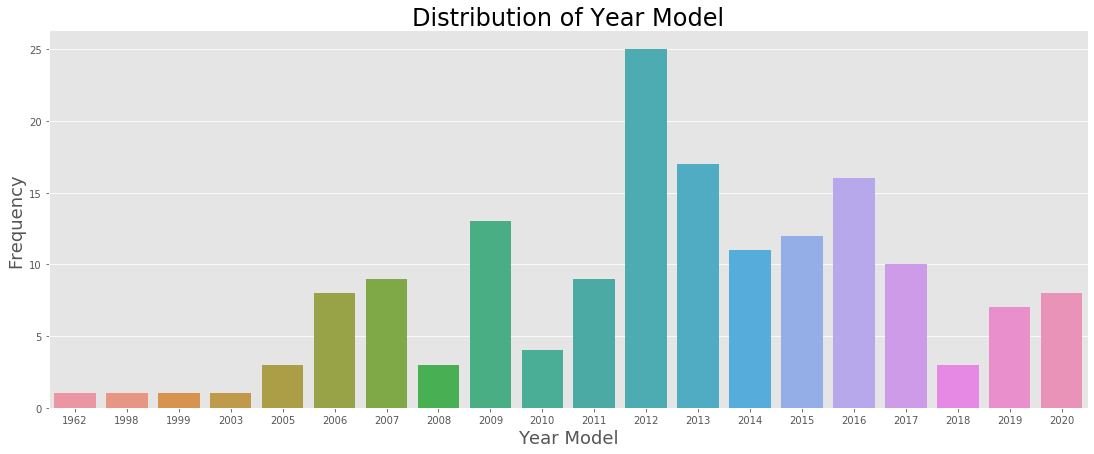

In [300]:
# Histogram of the year model
#df.year.plot(kind='hist',color='purple',edgecolor='black',figsize=(10,7))
sns.catplot(x="year", kind="count", data=df, height=6, aspect=2.5)
plt.title('Distribution of Year Model', size=24)
plt.xlabel('Year Model', size=18)
plt.ylabel('Frequency', size=18)

### Kms Attribute

In [301]:
df.kms.describe()

count       162.000000
mean      61958.302469
std       39344.646442
min           0.000000
25%       31000.000000
50%       60512.000000
75%       88490.750000
max      214000.000000
Name: kms, dtype: float64

Text(0, 0.5, 'Frequency')

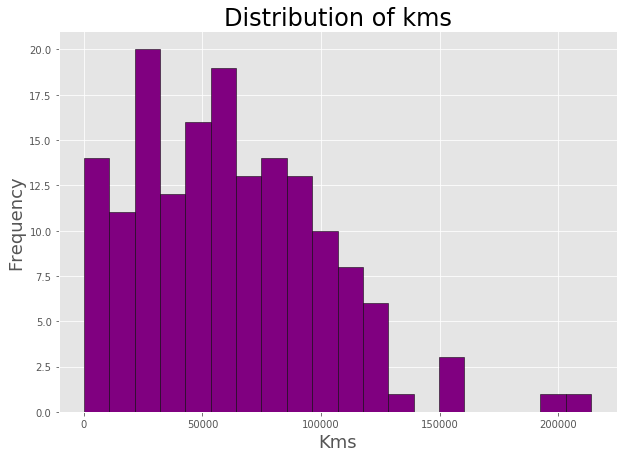

In [302]:
# Histogram of the kms
plt.style.use('ggplot')
df.kms.plot(kind='hist',color='purple',edgecolor='black',figsize=(10,7), bins=20)
plt.title('Distribution of kms', size=24)
plt.xlabel('Kms', size=18)
plt.ylabel('Frequency', size=18)

### Price Target

In [303]:
df.price.describe()

count    162.000000
mean      61.392901
std       25.352529
min       19.500000
25%       42.225000
50%       58.000000
75%       76.400000
max      131.900000
Name: price, dtype: float64

Text(0, 0.5, 'Frequency')

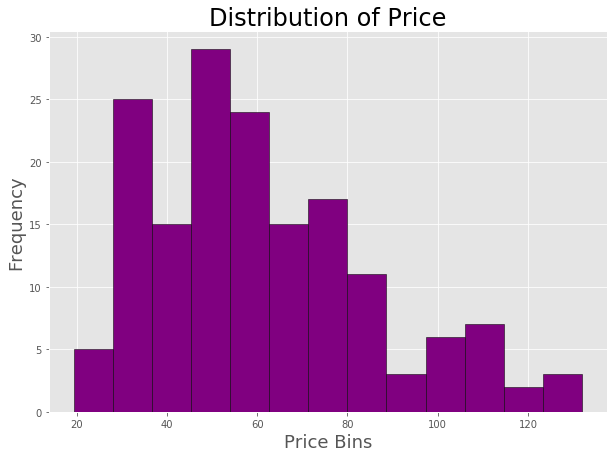

In [304]:
# Histogram of price
df.price.plot(kind='hist',color='purple',edgecolor='black',figsize=(10,7), bins=13)
plt.title('Distribution of Price', size=24)
plt.xlabel('Price Bins', size=18)
plt.ylabel('Frequency', size=18)

### Distributions by Year Model

Let's check the distributions based on year models.

In [305]:
df_year = df.groupby(df.year)

In [306]:
df_year.price.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1962,1.0,25.000000,NaN,25.00,25.0000,25.000,25.000,25.0
1998,1.0,20.000000,NaN,20.00,20.0000,20.000,20.000,20.0
1999,1.0,19.500000,NaN,19.50,19.5000,19.500,19.500,19.5
2003,1.0,22.000000,NaN,22.00,22.0000,22.000,22.000,22.0
2005,3.0,29.466667,1.342882,28.50,28.7000,28.900,29.950,31.0
2006,8.0,30.212500,1.398405,27.50,29.7250,30.200,31.125,32.0
2007,9.0,34.232222,3.976725,30.00,31.9000,33.490,35.000,43.5
2008,3.0,39.100000,6.436614,34.80,35.4000,36.000,41.250,46.5
2009,13.0,38.753846,4.251395,33.90,35.7000,38.000,38.900,48.0


Text(3.6750000000000043, 0.5, 'Price')

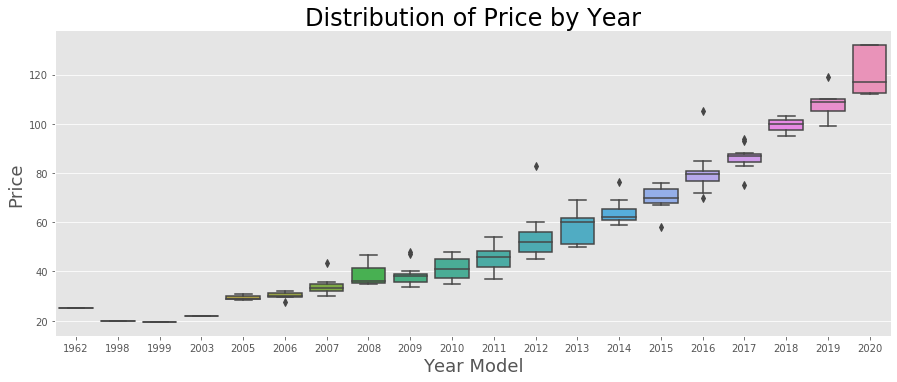

In [307]:
# Histogram of price by Year Model
sns.catplot(x="year", y="price", kind="box", data = df, height=5, aspect=2.5 )
plt.title('Distribution of Price by Year', size=24)
plt.xlabel('Year Model', size=18)
plt.ylabel('Price', size=18)

In [308]:
df_year.kms.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1962,1.0,96000.000000,NaN,96000.0,96000.0,96000.0,96000.00,96000.0
1998,1.0,120000.000000,NaN,120000.0,120000.0,120000.0,120000.00,120000.0
1999,1.0,200000.000000,NaN,200000.0,200000.0,200000.0,200000.00,200000.0
2003,1.0,214000.000000,NaN,214000.0,214000.0,214000.0,214000.00,214000.0
2005,3.0,108500.000000,20426.698216,85000.0,101750.0,118500.0,120250.00,122000.0
2006,8.0,118736.125000,21781.942327,93000.0,104250.0,115450.0,126747.25,152000.0
2007,9.0,93626.000000,20523.622993,63000.0,85000.0,91800.0,110000.00,120000.0
2008,3.0,107133.333333,12339.097752,95400.0,100700.0,106000.0,113000.00,120000.0
2009,13.0,95558.923077,32180.384215,26900.0,84651.0,91000.0,110000.00,156000.0


Text(-15.074999999999996, 0.5, 'KMS')

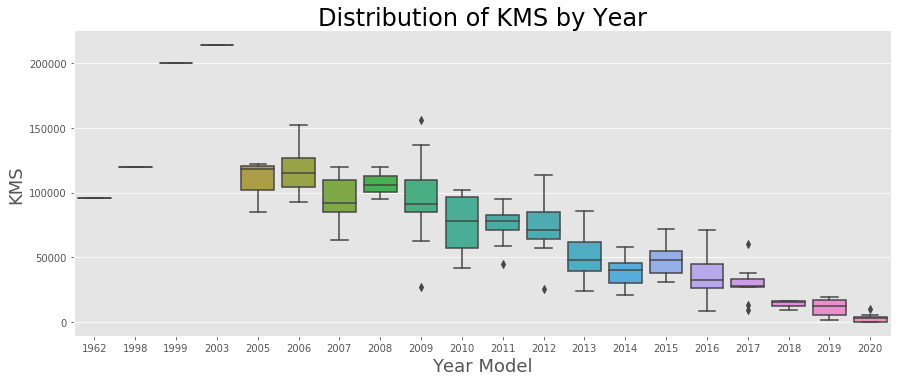

In [309]:
# Histogram of Kms by Year Model
sns.catplot(x="year", y="kms", kind="box", data = df, height=5, aspect=2.5 )
plt.title('Distribution of KMS by Year', size=24)
plt.xlabel('Year Model', size=18)
plt.ylabel('KMS', size=18)

We can see we have outliers in year price and kms attributes. we will remove them.

### Removing outliers

In [310]:
from scipy import stats
import numpy as np

First, I will check for outliers located further than 3 standard deviations.

In [311]:
z = np.abs(stats.zscore(df))
print(np.where(z>3))

(array([ 74,  78, 147], dtype=int64), array([2, 2, 1], dtype=int64))


In [312]:
df_z = df[(z < 3).all(axis=1)].copy()

In [313]:
df_z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 161
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   159 non-null    float64
 1   year    159 non-null    int64  
 2   kms     159 non-null    int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 4.3 KB


In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   162 non-null    float64
 1   year    162 non-null    int64  
 2   kms     162 non-null    int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 3.3 KB


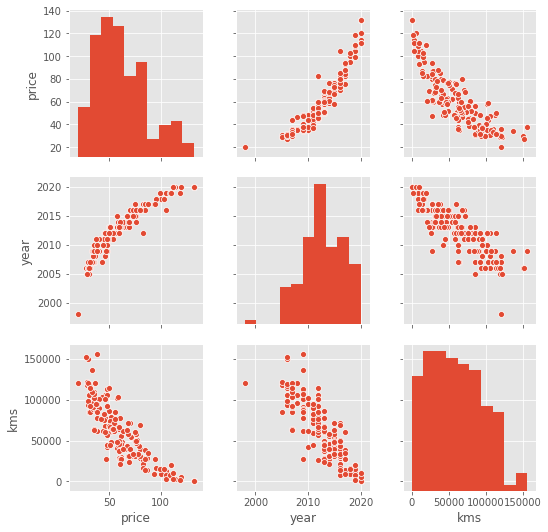

In [315]:
sns.pairplot(df_z)

Now let's check with IQR Score.

In [316]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

price       34.175
year         6.000
kms      57490.750
dtype: float64


In [317]:
df_iqr = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [318]:
df_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 0 to 161
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   155 non-null    float64
 1   year    155 non-null    int64  
 2   kms     155 non-null    int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 4.2 KB


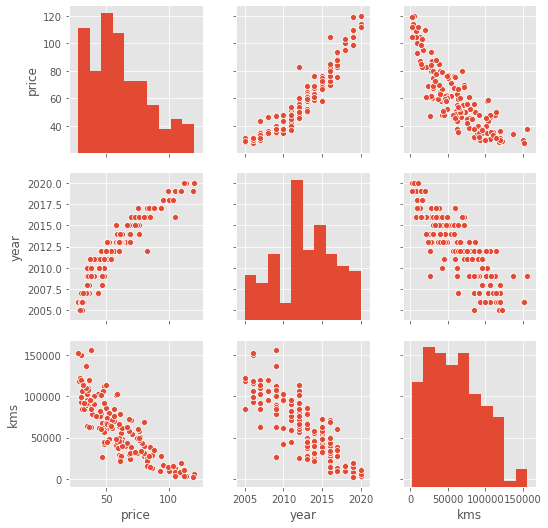

In [319]:
sns.pairplot(df_iqr)

We will choose IQR Score as it must robust for detecting outliers in oir dataset

We can combine all of the attributes in a single plot, by assigning the year model to colors. 
We can appeciate the different clusters.

Text(0, 0.5, 'Price')

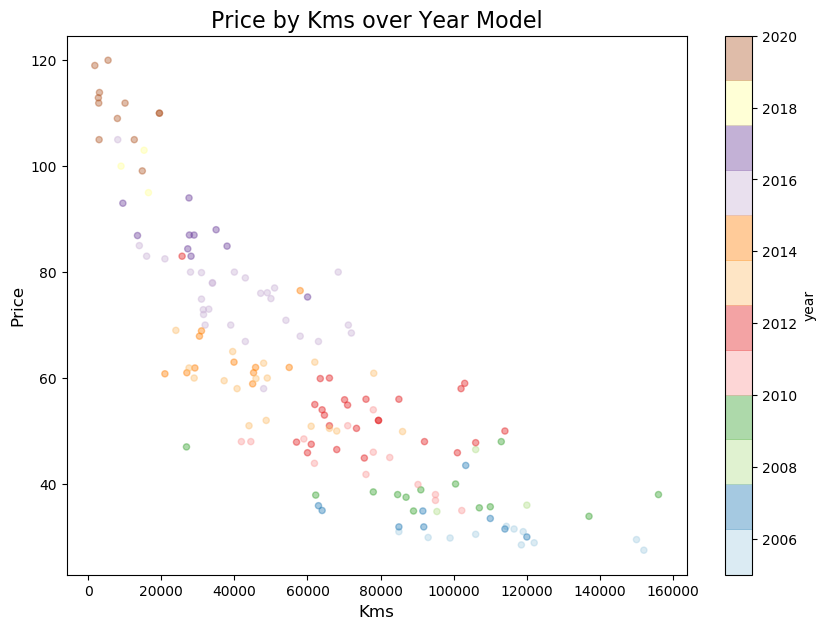

In [320]:
plt.style.use('default')
df_iqr.plot(kind="scatter", x="kms", y="price", alpha=0.4,
           figsize=(10,7), c="year", cmap=plt.get_cmap("Paired"), colorbar=True, sharex=False)
plt.title('Price by Kms over Year Model', size=16)
plt.xlabel('Kms', size=12)
plt.ylabel('Price', size=12)

### Correlations

Text(0.5, 1, 'Correlations Heatmap')

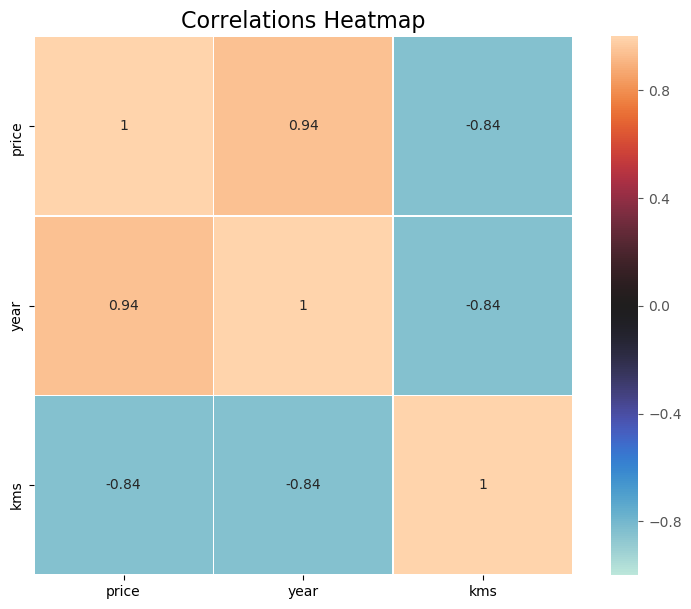

In [321]:
#Heatmap of correlations
corr = df_iqr.corr()
fig, ax = plt.subplots(figsize=(10,7))
plt.style.use('ggplot')
sns.heatmap(corr,
                 vmin=-1, vmax=1, center=0,
                 square=True, annot = True,
                linewidths=.5, ax=ax)
plt.title('Correlations Heatmap', size=16)

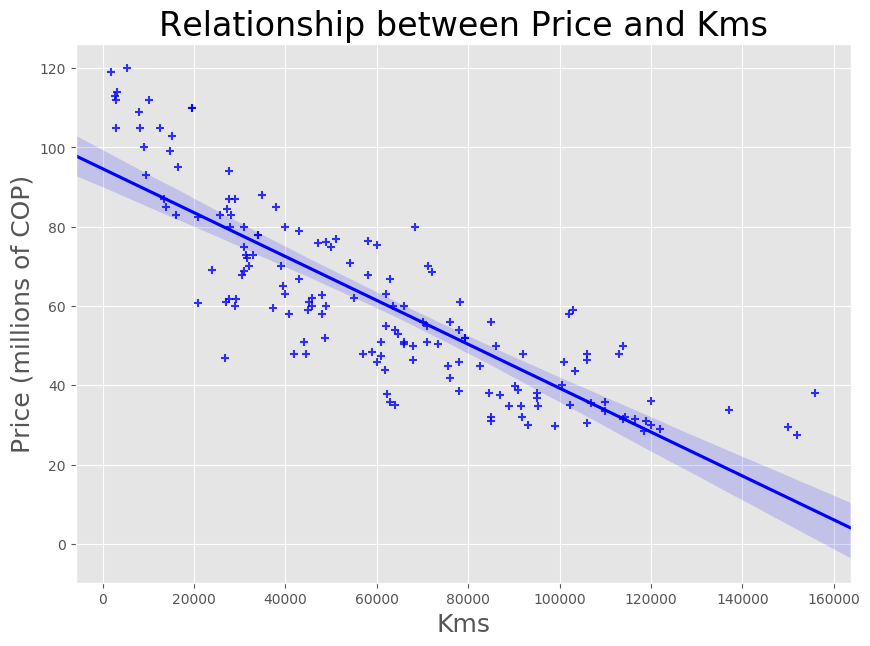

In [324]:
# Regression plot using seaborn.
fig = plt.figure(figsize=(10,7))
sns.regplot(x=df_iqr.kms,y=df_iqr.price,color='blue', marker='+')
plt.title('Relationship between Price and Kms', size=24)
plt.xlabel('Kms', size=18)
plt.ylabel('Price (millions of COP)', size=18);

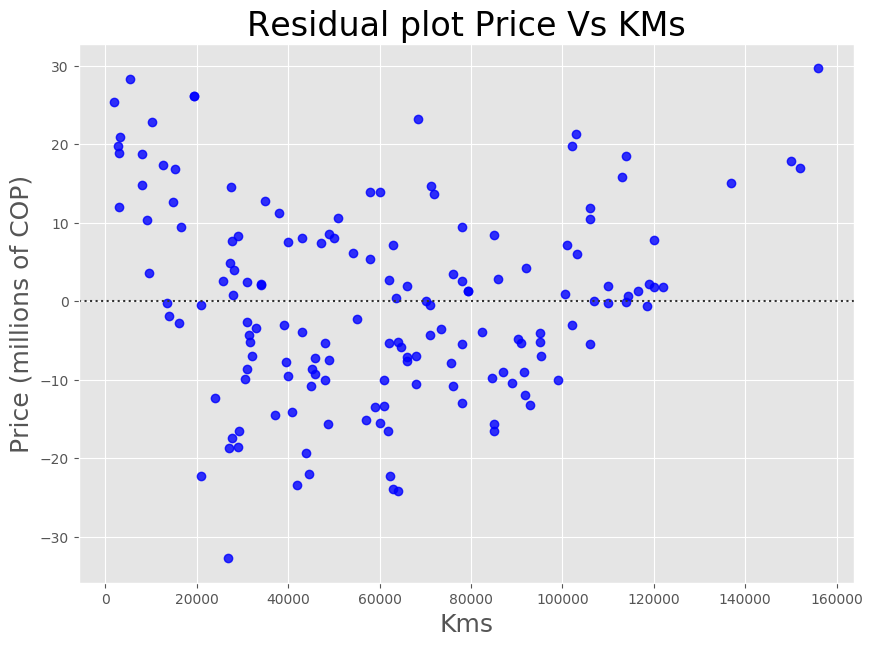

In [325]:
# Residual plot.
fig = plt.figure(figsize=(10,7))
sns.residplot(df_iqr.kms, df_iqr.price, color='blue')
plt.title('Residual plot Price Vs KMs', size=24)
plt.xlabel('Kms', size=18)
plt.ylabel('Price (millions of COP)', size=18);

Now this looks more like a exponential curve, so I will take the log to see

In [327]:
df_iqr = df_iqr.assign(price_log = lambda x: np.log(x.price))

In [328]:
df_iqr.head()

,price,year,kms,price_log
0,86.9,2017,13500,4.464758
1,49.9,2013,86000,3.910021
2,28.5,2005,118500,3.349904
3,110.0,2019,19500,4.700480
4,32.0,2006,114400,3.465736


Text(0, 0.5, 'Price_Log')

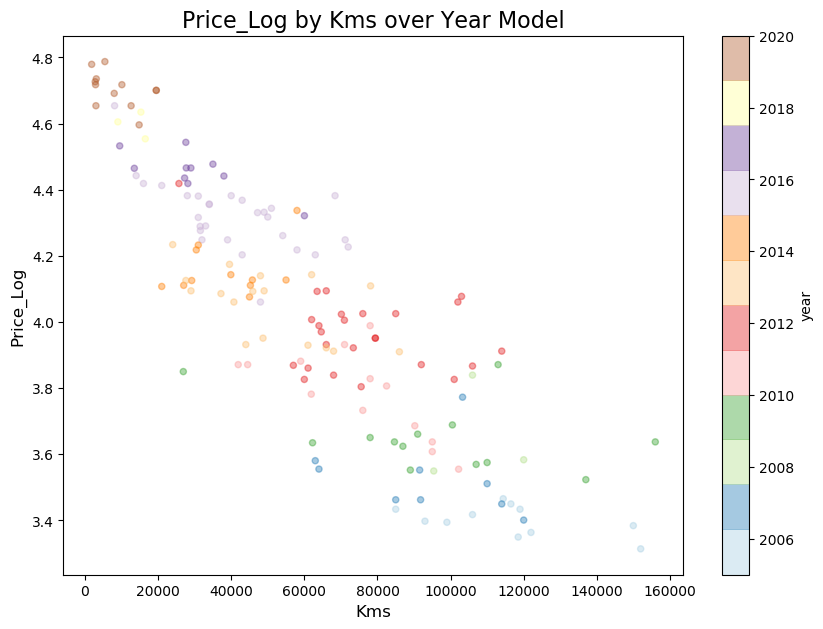

In [329]:
plt.style.use('default')
df_iqr.plot(kind="scatter", x="kms", y="price_log", alpha=0.4,
           figsize=(10,7), c="year", cmap=plt.get_cmap("Paired"), colorbar=True, sharex=False)
plt.title('Price_Log by Kms over Year Model', size=16)
plt.xlabel('Kms', size=12)
plt.ylabel('Price_Log', size=12)

Text(0.5, 1, 'Correlations Heatmap')

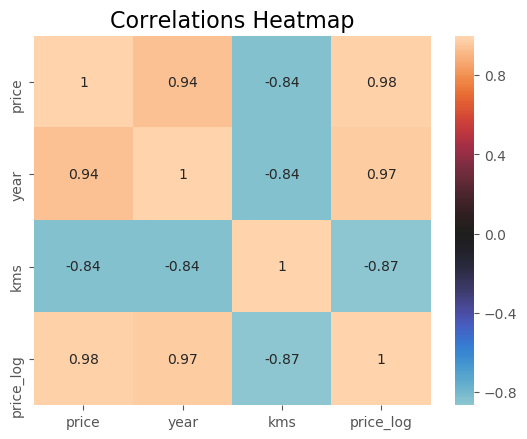

In [330]:
plt.style.use('ggplot')
sns.heatmap(df_iqr.corr(), annot =True, center =0)
plt.title('Correlations Heatmap', size=16)

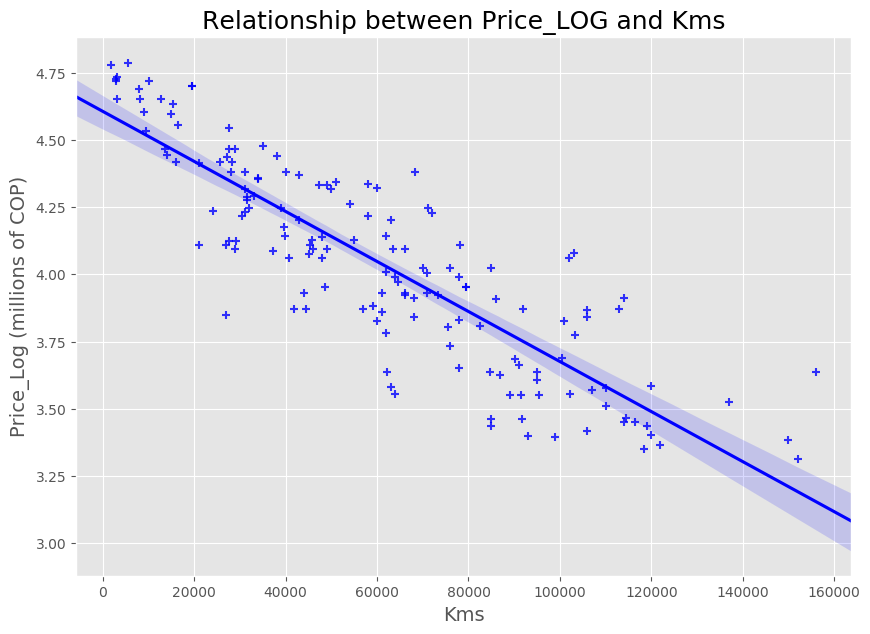

In [333]:
# Regression plot using seaborn.
plt.style.use('ggplot')
fig = plt.figure(figsize=(10,7))
sns.regplot(x=df_iqr.kms,y=df_iqr.price_log,color='blue', marker='+')
plt.title('Relationship between Price_LOG and Kms', size=18)
plt.xlabel('Kms', size=14)
plt.ylabel('Price_Log (millions of COP)', size=14);

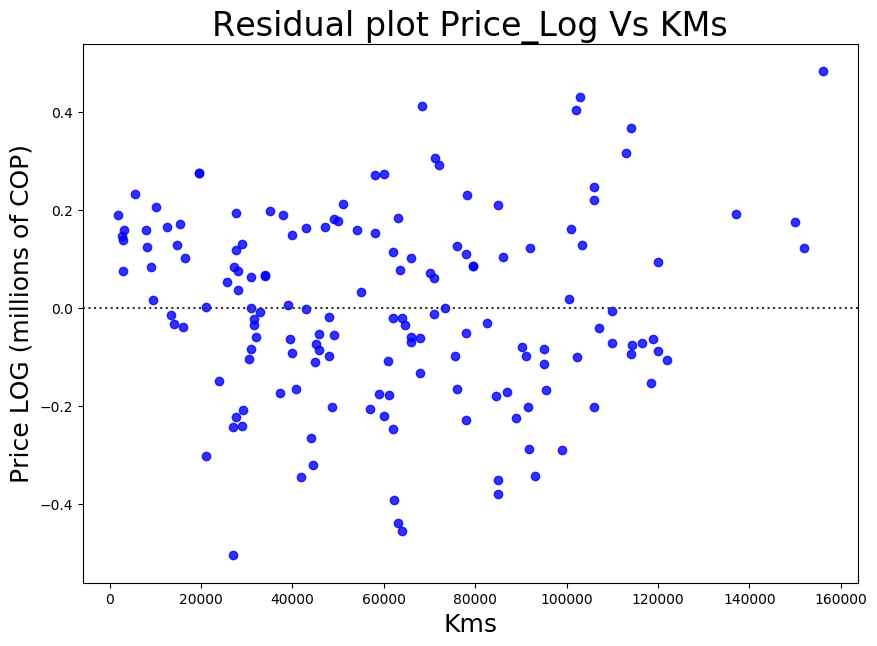

In [227]:
# Residual plot.
fig = plt.figure(figsize=(10,7))
sns.residplot(df_iqr.kms, df_iqr.price_log, color='blue')
plt.title('Residual plot Price_Log Vs KMs', size=18)
plt.xlabel('Kms', size=14)
plt.ylabel('Price LOG (millions of COP)', size=14);

Perfect so to sum up, I will write a function to transform our data

In [228]:
def transformData(df):
    # Remove Outliers using IQR Score
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_iqr = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    #Add logPrice column
    df_iqr = df_iqr.assign(price_log = lambda x: np.log(x.price))
    
    return df_iqr

Now let's test our new function transformData

In [229]:
df = pd.read_csv('files/vehicles.csv')
df = prepareData(df)
df = transformData(df)

In [161]:
df.head()

,price,year,kms,price_log
0,86.9,2017,13500,4.464758
1,49.9,2013,86000,3.910021
2,28.5,2005,118500,3.349904
3,110.0,2019,19500,4.700480
4,32.0,2006,114400,3.465736


## Calculating Regressions

Now we are ready to make our regression calculations. I want to test two Regression: Linear regression, using my categorical data year model and a non-linear regression.

In [171]:
df = df.sort_values('kms')
X = df.iloc[:,2:3]
y = df.iloc[:,3]

### Linear Regression

In [231]:
from sklearn.linear_model import LinearRegression

# Create linear regression object.
mlr= LinearRegression()

# Fit linear regression.
mlr.fit(df[['kms','year']], df['price_log'])

# Get the slope and intercept of the line best fit.
print(mlr.intercept_)
print(mlr.coef_)

-158.1924976714874
[-2.02620015e-06  8.06647554e-02]


Now as we saw in the Data assessment, the data can have outliers. And this is normal, basically a Seller can put the price that he wants. Also we can have cars with a lot of kilometers. Because of this is better to use mean absolute error as our performance measure.

In [232]:
from sklearn.metrics import mean_absolute_error
estimated_prices = np.exp(mlr.predict(df[['kms','year']]))
lin_mae = mean_absolute_error(df['price'], estimated_prices)
lin_mae

3.7660973862461753

Just as a reference Mean Squar Error

In [164]:
# Mean Squared Error
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(df_iqr['price'], estimated_prices)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

5.283296391727104

Now we are ready to do some predictions.

In [187]:
# Predictions using scikit learn.
KMS = 40000
YEAR_MODEL = 2009

print(np.exp(mlr.predict([[KMS,YEAR_MODEL]])))

[43.9014732]


We can print the results in another column to inspect the differences

In [166]:
df_result = df.assign(predicted = estimated_prices)

In [167]:
df_result.head(10)

,price,year,kms,price_log,predicted
0,86.9,2017,13500,4.464758,88.319438
1,49.9,2013,86000,3.910021,55.224224
2,28.5,2005,118500,3.349904,27.118934
3,110.0,2019,19500,4.700480,102.527652
4,32.0,2006,114400,3.465736,29.642357
5,80.0,2016,28000,4.382027,79.116035
6,72.0,2016,31572,4.276666,78.545493
7,58.0,2013,40736,4.060443,60.528578
8,38.9,2009,91000,3.660994,39.591390
9,59.5,2013,37200,4.085976,60.963801


### Non-Linear Regression

In [168]:
df = df.sort_values('kms')
X = df.iloc[:,2:3]
y = df.iloc[:,3]

In [169]:
# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 3) 
X_poly = poly.fit_transform(X) 
  
poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

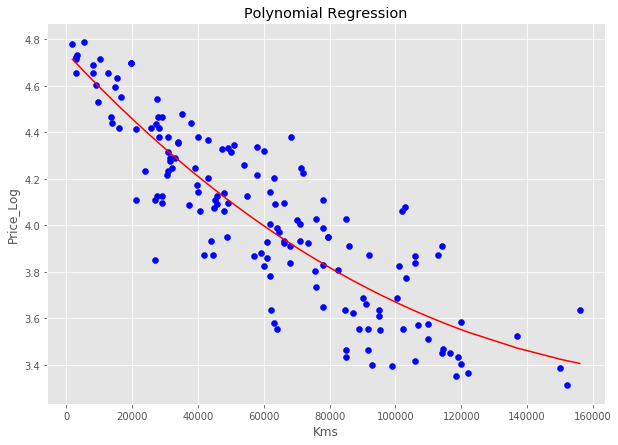

In [180]:
# Visualising the Polynomial Regression results
fig = plt.figure(figsize=(10,7))
plt.scatter(X, y, color = 'blue')   
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Kms') 
plt.ylabel('Price_Log') 
  
plt.show() 

In [183]:
from sklearn.metrics import mean_absolute_error
estimated_prices = np.exp(lin2.predict(poly.fit_transform(X)))
lin_mae = mean_absolute_error(df['price'], estimated_prices)
lin_mae

8.16121076707006

In [188]:
df_result = df_result.assign(predicted_poly = estimated_prices)

In [189]:
df_result.head(10)

,price,year,kms,price_log,predicted,predicted_poly
0,86.9,2017,13500,4.464758,88.319438,111.598312
1,49.9,2013,86000,3.910021,55.224224,109.996938
2,28.5,2005,118500,3.349904,27.118934,109.833381
3,110.0,2019,19500,4.700480,102.527652,109.670171
4,32.0,2006,114400,3.465736,29.642357,109.507308
5,80.0,2016,28000,4.382027,79.116035,105.777809
6,72.0,2016,31572,4.276666,78.545493,101.934701
7,58.0,2013,40736,4.060443,60.528578,101.788141
8,38.9,2009,91000,3.660994,39.591390,100.482798
9,59.5,2013,37200,4.085976,60.963801,99.768133
